In [94]:
import warnings
warnings.filterwarnings("ignore")

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve,train_test_split,cross_validate, ShuffleSplit,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import seaborn as sns
from sklearn.svm import LinearSVC

Primero necesitamos cargar el dataset

In [96]:
train = pd.read_csv('../train.csv')
train.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


In [97]:
train.ID.size

692500

In [98]:
train.isnull().sum()

ID                                    0
PERIODO                               0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_VALORMATRICULAUNIVERSIDAD     6287
ESTU_HORASSEMANATRABAJA           30857
FAMI_ESTRATOVIVIENDA              32137
FAMI_TIENEINTERNET                26629
FAMI_EDUCACIONPADRE               23178
FAMI_EDUCACIONMADRE               23664
ESTU_PAGOMATRICULAPROPIO           6498
RENDIMIENTO_GLOBAL                    0
dtype: int64

Hay que tener en cuenta que son un total de 301468 datos, por lo que igualmente en el peor de los casos 13925 equivale unicamente al 4.61% de los datos, de manera que consideramos que agregar datos no dañara los resultados.

En este caso entonces decidimos añadir los datos faltantes en forma de la moda, esto no fue arbitrario sino fue hecho porque los datos son de tipo objeto, por lo que en varios casos realmente no representan un valor numerico.

In [99]:
train = train.apply(lambda x: x.fillna(x.value_counts().index[0]))
train.isnull().sum()

ID                                0
PERIODO                           0
ESTU_PRGM_ACADEMICO               0
ESTU_PRGM_DEPARTAMENTO            0
ESTU_VALORMATRICULAUNIVERSIDAD    0
ESTU_HORASSEMANATRABAJA           0
FAMI_ESTRATOVIVIENDA              0
FAMI_TIENEINTERNET                0
FAMI_EDUCACIONPADRE               0
FAMI_EDUCACIONMADRE               0
ESTU_PAGOMATRICULAPROPIO          0
RENDIMIENTO_GLOBAL                0
dtype: int64

Ahora revisamos cuales son los valores únicos de cada columna

In [100]:
train.nunique()

ID                                692500
PERIODO                                9
ESTU_PRGM_ACADEMICO                  948
ESTU_PRGM_DEPARTAMENTO                31
ESTU_VALORMATRICULAUNIVERSIDAD         8
ESTU_HORASSEMANATRABAJA                5
FAMI_ESTRATOVIVIENDA                   7
FAMI_TIENEINTERNET                     2
FAMI_EDUCACIONPADRE                   12
FAMI_EDUCACIONMADRE                   12
ESTU_PAGOMATRICULAPROPIO               2
RENDIMIENTO_GLOBAL                     4
dtype: int64

El ID y el periodo podemos no tomarlos en cuenta directamente porque no representan un efecto directo con el rendimiento global.

In [101]:
train = train.drop('ID', axis=1)
train = train.drop('PERIODO', axis=1)
train.head()

,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


Los valores de matricula universidad los convertimos a numericos ordenandolos de 1 a n de menor a mayor de los gastos de matricula.

In [102]:
valores = train.ESTU_VALORMATRICULAUNIVERSIDAD.unique()
valores

array(['Entre 5.5 millones y menos de 7 millones',
       'Entre 2.5 millones y menos de 4 millones',
       'Entre 4 millones y menos de 5.5 millones', 'Más de 7 millones',
       'Entre 1 millón y menos de 2.5 millones',
       'Entre 500 mil y menos de 1 millón', 'Menos de 500 mil',
       'No pagó matrícula'], dtype=object)

In [103]:
def cambio(x):
  try:
    newval = x.split(' ')[1]
    newval2 = x.split(' ')[2]
    newval = float(newval)
    if x.split(' ')[2] == 'mil':
      newval = newval/1000
    return newval
  except:
    try:
      newval = float(newval2)
      if x.split(' ')[0] == 'Menos':
        newval = .25
    except:
      return 0
    return newval
valores2 = list(map(cambio, valores))
valores2

[5.5, 2.5, 4.0, 7.0, 1.0, 0.5, 0.25, 0]

In [104]:
replacement = dict(zip(valores, valores2))
replacement

{'Entre 5.5 millones y menos de 7 millones': 5.5,
 'Entre 2.5 millones y menos de 4 millones': 2.5,
 'Entre 4 millones y menos de 5.5 millones': 4.0,
 'Más de 7 millones': 7.0,
 'Entre 1 millón y menos de 2.5 millones': 1.0,
 'Entre 500 mil y menos de 1 millón': 0.5,
 'Menos de 500 mil': 0.25,
 'No pagó matrícula': 0}

In [105]:
# utilizar este diccionario para reemplzar los valores de la columna
train['ESTU_VALORMATRICULAUNIVERSIDAD'] = train['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(replacement)
train

,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,ENFERMERIA,BOGOTÁ,5.5,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,DERECHO,ATLANTICO,2.5,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,MERCADEO Y PUBLICIDAD,BOGOTÁ,2.5,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,ADMINISTRACION DE EMPRESAS,SANTANDER,4.0,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,PSICOLOGIA,ANTIOQUIA,2.5,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo
...,...,...,...,...,...,...,...,...,...,...
692495,BIOLOGIA,LA GUAJIRA,0.5,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) incompleta,Si,medio-alto
692496,PSICOLOGIA,NORTE SANTANDER,2.5,Más de 30 horas,Estrato 3,Si,Primaria incompleta,Secundaria (Bachillerato) incompleta,No,bajo
692497,ADMINISTRACIÓN EN SALUD OCUPACIONAL,BOGOTÁ,1.0,Menos de 10 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) incompleta,Si,medio-bajo
692498,PSICOLOGIA,TOLIMA,2.5,Menos de 10 horas,Estrato 1,No,Primaria completa,Primaria completa,Si,bajo


# Ahora haremos lo mismo con horas trabaja semana

In [106]:
valores = train.ESTU_HORASSEMANATRABAJA.unique()
valores

array(['Menos de 10 horas', '0', 'Más de 30 horas', 'Entre 21 y 30 horas',
       'Entre 11 y 20 horas'], dtype=object)

In [107]:
def cambio(x):
  xsplited = x.split(' ')
  if len(xsplited) == 1:
    return 0
  xsplited = list(filter(lambda x: True if str(x).isdigit() else False, map(lambda x: int(x) if x.isdigit() else x, xsplited)))
  return xsplited[0]

In [108]:
valores2 = list(map(cambio, valores))
valores2

[10, 0, 30, 21, 11]

In [109]:
replacement = dict(zip(valores, valores2))
replacement

{'Menos de 10 horas': 10,
 '0': 0,
 'Más de 30 horas': 30,
 'Entre 21 y 30 horas': 21,
 'Entre 11 y 20 horas': 11}

In [110]:
train['ESTU_HORASSEMANATRABAJA'] = train['ESTU_HORASSEMANATRABAJA'].replace(replacement)
train

,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,ENFERMERIA,BOGOTÁ,5.5,10,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,DERECHO,ATLANTICO,2.5,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,MERCADEO Y PUBLICIDAD,BOGOTÁ,2.5,30,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,ADMINISTRACION DE EMPRESAS,SANTANDER,4.0,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,PSICOLOGIA,ANTIOQUIA,2.5,21,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo
...,...,...,...,...,...,...,...,...,...,...
692495,BIOLOGIA,LA GUAJIRA,0.5,11,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) incompleta,Si,medio-alto
692496,PSICOLOGIA,NORTE SANTANDER,2.5,30,Estrato 3,Si,Primaria incompleta,Secundaria (Bachillerato) incompleta,No,bajo
692497,ADMINISTRACIÓN EN SALUD OCUPACIONAL,BOGOTÁ,1.0,10,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) incompleta,Si,medio-bajo
692498,PSICOLOGIA,TOLIMA,2.5,10,Estrato 1,No,Primaria completa,Primaria completa,Si,bajo


Ahora con FAMI_ESTRATOVIVIENDA

In [111]:
valores = train.FAMI_ESTRATOVIVIENDA.unique()
valores

array(['Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 2', 'Estrato 1',
       'Estrato 6', 'Sin Estrato'], dtype=object)

In [112]:
valores2 = list(map(lambda x: int(x.split(' ')[1]) if x.split(' ')[1].isdigit() else 0, valores))
valores2

[3, 4, 5, 2, 1, 6, 0]

In [113]:
replacement = dict(zip(valores, valores2))
replacement

{'Estrato 3': 3,
 'Estrato 4': 4,
 'Estrato 5': 5,
 'Estrato 2': 2,
 'Estrato 1': 1,
 'Estrato 6': 6,
 'Sin Estrato': 0}

In [114]:
train['FAMI_ESTRATOVIVIENDA'] = train['FAMI_ESTRATOVIVIENDA'].replace(replacement)
train

,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,ENFERMERIA,BOGOTÁ,5.5,10,3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,DERECHO,ATLANTICO,2.5,0,3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,MERCADEO Y PUBLICIDAD,BOGOTÁ,2.5,30,3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,ADMINISTRACION DE EMPRESAS,SANTANDER,4.0,0,4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,PSICOLOGIA,ANTIOQUIA,2.5,21,3,Si,Primaria completa,Primaria completa,No,medio-bajo
...,...,...,...,...,...,...,...,...,...,...
692495,BIOLOGIA,LA GUAJIRA,0.5,11,2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) incompleta,Si,medio-alto
692496,PSICOLOGIA,NORTE SANTANDER,2.5,30,3,Si,Primaria incompleta,Secundaria (Bachillerato) incompleta,No,bajo
692497,ADMINISTRACIÓN EN SALUD OCUPACIONAL,BOGOTÁ,1.0,10,3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) incompleta,Si,medio-bajo
692498,PSICOLOGIA,TOLIMA,2.5,10,1,No,Primaria completa,Primaria completa,Si,bajo


FAMI_TIENEINTERNET y  ESTU_PAGOMATRICULAPROPIO que tienen los mismos posibles datos

In [115]:
valores1 = train.FAMI_TIENEINTERNET.unique()
valores1

array(['Si', 'No'], dtype=object)

In [116]:
valores = train.ESTU_PAGOMATRICULAPROPIO.unique()
valores

array(['No', 'Si'], dtype=object)

Ahora no será 0 y si será 1.

In [117]:
replacement = dict(zip(valores, [0,1]))
replacement

{'No': 0, 'Si': 1}

In [118]:
train['FAMI_TIENEINTERNET'] = train['FAMI_TIENEINTERNET'].replace(replacement)
train['ESTU_PAGOMATRICULAPROPIO'] = train['ESTU_PAGOMATRICULAPROPIO'].replace(replacement)

FAMI_EDUCACIONPADRE y FAMI_EDUCACIONMADRE que tienen los mismos tipos de dato.

In [119]:
valores = train.FAMI_EDUCACIONPADRE.unique()
valores

array(['Técnica o tecnológica incompleta',
       'Técnica o tecnológica completa',
       'Secundaria (Bachillerato) completa', 'No sabe',
       'Primaria completa', 'Educación profesional completa',
       'Educación profesional incompleta', 'Primaria incompleta',
       'Postgrado', 'Secundaria (Bachillerato) incompleta', 'Ninguno',
       'No Aplica'], dtype=object)

Se seleccionan por decisión del programador cuales son los valores de educación correspondiente para cada uno de los posibles niveles encuestados, tomando NA, Ninguno y no sabe como 0.

In [120]:
educacion_numerica = {
    'No Aplica': 0,
    'Ninguno': 0,
    'No sabe': 0,
    'Primaria incompleta': 1,
    'Primaria completa': 2,
    'Secundaria (Bachillerato) incompleta': 3,
    'Secundaria (Bachillerato) completa': 4,
    'Técnica o tecnológica incompleta': 5,
    'Técnica o tecnológica completa': 6,
    'Educación profesional incompleta': 7,
    'Educación profesional completa': 8,
    'Postgrado': 9
}


In [121]:
train['FAMI_EDUCACIONPADRE'] = train['FAMI_EDUCACIONPADRE'].replace(educacion_numerica)
train['FAMI_EDUCACIONMADRE'] = train['FAMI_EDUCACIONMADRE'].replace(educacion_numerica)

Por ultimo (entre los que podemos convertir a numeros de manera logica) tomamos rendimiento global y lo ponemos de 1 a 4.

In [122]:
train.RENDIMIENTO_GLOBAL.unique()

array(['medio-alto', 'bajo', 'alto', 'medio-bajo'], dtype=object)

In [123]:
replacement = dict(zip(train.RENDIMIENTO_GLOBAL.unique(), [3,1,4,2]))
replacement

{'medio-alto': 3, 'bajo': 1, 'alto': 4, 'medio-bajo': 2}

In [124]:
train['RENDIMIENTO_GLOBAL'] = train['RENDIMIENTO_GLOBAL'].replace(replacement)
train.head()

,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,ENFERMERIA,BOGOTÁ,5.5,10,3,1,5,9,0,3
1,DERECHO,ATLANTICO,2.5,0,3,0,6,5,0,1
2,MERCADEO Y PUBLICIDAD,BOGOTÁ,2.5,30,3,1,4,4,0,1
3,ADMINISTRACION DE EMPRESAS,SANTANDER,4.0,0,4,1,0,4,0,4
4,PSICOLOGIA,ANTIOQUIA,2.5,21,3,1,2,2,0,2


Para el departamento se realiza un onehotencoding y para el programa academico se realiza una codificación categorica, de manera que ahora cada uno simplemente se va a representar con un numero de 1 a N sea N el numero total de programas academicos.

In [125]:
train = pd.get_dummies(train, columns=['ESTU_PRGM_DEPARTAMENTO'])
train.head()
train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].astype('category').cat.codes
train.head()

,ESTU_PRGM_ACADEMICO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,...,ESTU_PRGM_DEPARTAMENTO_NORTE SANTANDER,ESTU_PRGM_DEPARTAMENTO_PUTUMAYO,ESTU_PRGM_DEPARTAMENTO_QUINDIO,ESTU_PRGM_DEPARTAMENTO_RISARALDA,ESTU_PRGM_DEPARTAMENTO_SAN ANDRES,ESTU_PRGM_DEPARTAMENTO_SANTANDER,ESTU_PRGM_DEPARTAMENTO_SUCRE,ESTU_PRGM_DEPARTAMENTO_TOLIMA,ESTU_PRGM_DEPARTAMENTO_VALLE,ESTU_PRGM_DEPARTAMENTO_VAUPES
0,300,5.5,10,3,1,5,9,0,3,False,...,False,False,False,False,False,False,False,False,False,False
1,249,2.5,0,3,0,6,5,0,1,False,...,False,False,False,False,False,False,False,False,False,False
2,819,2.5,30,3,1,4,4,0,1,False,...,False,False,False,False,False,False,False,False,False,False
3,14,4.0,0,4,1,0,4,0,4,False,...,False,False,False,False,False,True,False,False,False,False
4,907,2.5,21,3,1,2,2,0,2,False,...,False,False,False,False,False,False,False,False,False,False


Ahora normalizamos todas las columnas de 0 a 1

Esto será importante pues permitirá que el código por su propia cuenta elija el "peso" de cada caracteristica, y no será afectado por el usuario.

In [126]:
maxim = train.max()
minim = train.min()
for i in train.columns:
  if i != 'RENDIMIENTO_GLOBAL' and type(maxim[i]) != np.bool_:
    train[i] = train[i].apply(lambda x: (x-minim[i])/(maxim[i]-minim[i]))
train.head()


,ESTU_PRGM_ACADEMICO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,...,ESTU_PRGM_DEPARTAMENTO_NORTE SANTANDER,ESTU_PRGM_DEPARTAMENTO_PUTUMAYO,ESTU_PRGM_DEPARTAMENTO_QUINDIO,ESTU_PRGM_DEPARTAMENTO_RISARALDA,ESTU_PRGM_DEPARTAMENTO_SAN ANDRES,ESTU_PRGM_DEPARTAMENTO_SANTANDER,ESTU_PRGM_DEPARTAMENTO_SUCRE,ESTU_PRGM_DEPARTAMENTO_TOLIMA,ESTU_PRGM_DEPARTAMENTO_VALLE,ESTU_PRGM_DEPARTAMENTO_VAUPES
0,0.316790,0.785714,0.333333,0.500000,1.0,0.555556,1.000000,0.0,3,False,...,False,False,False,False,False,False,False,False,False,False
1,0.262936,0.357143,0.000000,0.500000,0.0,0.666667,0.555556,0.0,1,False,...,False,False,False,False,False,False,False,False,False,False
2,0.864836,0.357143,1.000000,0.500000,1.0,0.444444,0.444444,0.0,1,False,...,False,False,False,False,False,False,False,False,False,False
3,0.014784,0.571429,0.000000,0.666667,1.0,0.000000,0.444444,0.0,4,False,...,False,False,False,False,False,True,False,False,False,False
4,0.957761,0.357143,0.700000,0.500000,1.0,0.222222,0.222222,0.0,2,False,...,False,False,False,False,False,False,False,False,False,False


Por ultimo revisamos las correlaciones

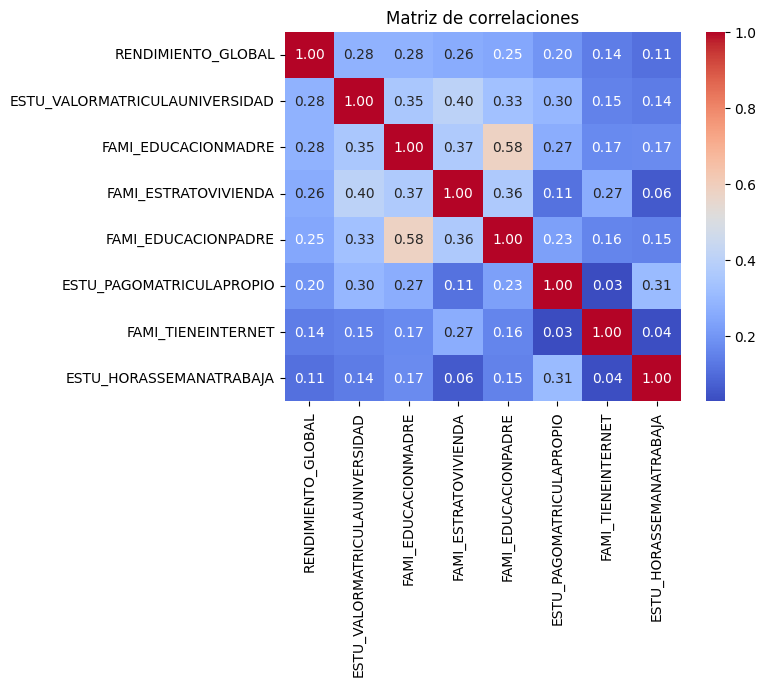

In [127]:
corr_matrix = np.abs(train.corr())
top = corr_matrix['RENDIMIENTO_GLOBAL'].sort_values(ascending=False)[0:8].index
corr_matrix = corr_matrix.loc[top, top]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlaciones")
plt.show()

Es importante notar aqui al final que los valores obtenidos de correlacion han mejorado respecto a la exploración, esto puede ser en gran medida porque los valores fueron tratados de mejor manera por lo que puede que los pesos de cada valor tengan un mayor sentido.

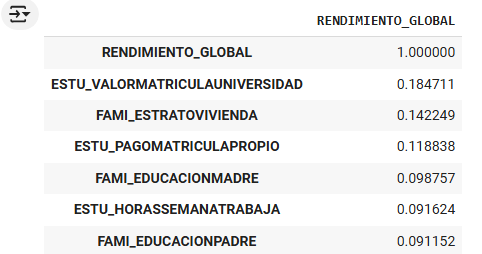
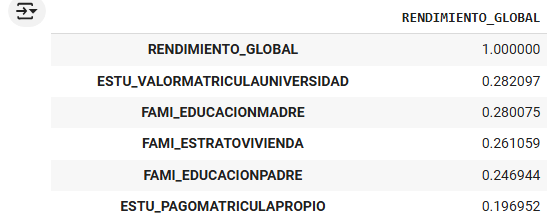

Por ultimo exportamos los datos

In [128]:
train.to_csv("../preprocesados.csv", index=False)

In [129]:
train = pd.read_csv("../preprocesados.csv")

# **ENTRENAMIENTO**

Para el modelo solución se eligió SVR + RandomForest, con la segunda forma de preprocesado desarrollada entre los dos estudiantes.

In [130]:
def report_cv_score(z):
    
    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSLE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSLE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [131]:
#Función para calcular el RMSLE de los modelos implementados
def RMSLE(y_actual, y_pred):
    
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [167]:
X = train.drop(['RENDIMIENTO_GLOBAL'],axis = 1)
y = train['RENDIMIENTO_GLOBAL'].values

In [133]:
#--------Partición de los datos------------

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(692500, 39) (692500,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(484750, 39) (207750, 39)


In [153]:
Modelo2 = LinearSVC(max_iter=5000)
Modelo3= RandomForestClassifier(n_estimators = 2,max_depth = 5)

In [154]:
def train_test_evaluate(model_name, model, X_train, y_train, X_test, y_test):
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Calcular razones en relación al promedio del valor real
    y_test_mean = y_test.mean()
    mae_ratio = mae / y_test_mean
    rmse_ratio = rmse / y_test_mean
    result_df = pd.DataFrame(
        data=[[model_name, mae, mse, rmse, r2, mae_ratio, rmse_ratio]],
        columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"]
    )
    return result_df


In [155]:
train_test_evaluate("SVR",Modelo2,Xtv,ytv,Xts,yts)


,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,SVR,1.051451,2.109242,1.452323,-0.67691,0.419989,0.580113


In [156]:
train_test_evaluate("RandomForest",Modelo3,Xtv,ytv,Xts,yts)

,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RandomForest,0.989324,1.85161,1.360739,-0.472085,0.395173,0.543531


In [160]:
zscores = []
estimators = [Modelo3, Modelo2]
names=["Random Forest inicial", 'SVR']
for i in range(len(estimators)):
    print("---------")
    z = cross_validate(estimators[i], Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
    if i==0:
        estimators[i].fit(Xtv, ytv)
        result_df= train_test_evaluate(names[i], estimators[i], Xtv, ytv, Xts, yts)
    else:
        estimators[i].fit(Xtv, ytv)
        df1=train_test_evaluate(names[i], estimators[i], Xtv, ytv, Xts, yts)
        result_df=pd.concat([result_df,df1],ignore_index=True)

    
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSLE Test:  1.42948 (± 0.02938594 )
RMSLE Train:  1.42834 (± 0.02835241 )
---------
RMSLE Test:  1.45361 (± 0.00301521 )
RMSLE Train:  1.45221 (± 0.00295989 )
Seleccionado:  0

 Mejor modelo: 
RandomForestClassifier(max_depth=5, n_estimators=2)


In [161]:
parametros = {
    "n_estimators": list(range(20, 61, 20)),
    "max_depth": list(range(11, 20, 2)),
    "min_samples_leaf": list(range(1, 3)),
    "random_state": [23]
}

forest_reg = GridSearchCV(estimator = Modelo3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs=-1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestClassifier(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [162]:
forest_reg.best_params_

{'max_depth': 19,
 'min_samples_leaf': 2,
 'n_estimators': 60,
 'random_state': 23}

In [163]:
Rdm_forest = RandomForestClassifier(n_estimators =forest_reg.best_params_["n_estimators"]
                                    ,max_depth = forest_reg.best_params_["max_depth"]
                                    ,min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                    random_state=forest_reg.best_params_["random_state"])

In [164]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")
    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

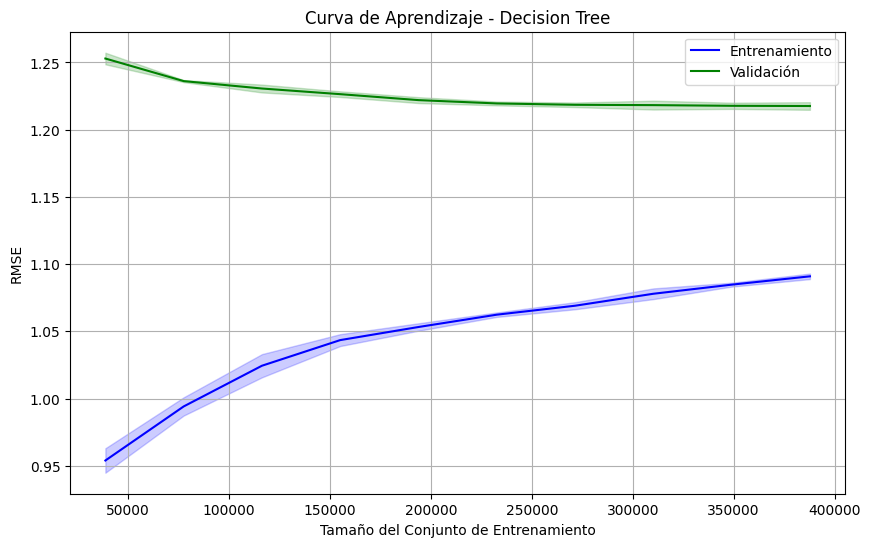

In [165]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    Rdm_forest, Xtv, ytv, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse.mean(axis=1), label="Entrenamiento", color='blue')
plt.plot(train_sizes, test_rmse.mean(axis=1), label="Validación", color='green')
plt.fill_between(train_sizes, train_rmse.mean(axis=1) - train_rmse.std(axis=1), 
                 train_rmse.mean(axis=1) + train_rmse.std(axis=1), alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_rmse.mean(axis=1) - test_rmse.std(axis=1), 
                 test_rmse.mean(axis=1) + test_rmse.std(axis=1), alpha=0.2, color='green')

plt.title('Curva de Aprendizaje - Decision Tree')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [168]:
Rdm_forest.fit(X, y)

RandomForestClassifier(max_depth=19, min_samples_leaf=2, n_estimators=60,
                       random_state=23)

Finalmente realizamos las pruebas con el archivo test

In [169]:
test = pd.read_csv('../test.csv').iloc[:,1:]
test.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No


Definimos una rutina para ejecutar con los datos de la misma manera.

In [171]:
def tratar_datos(df):
    df = df.drop('PERIODO', axis=1)
    replacement = {'Entre 5.5 millones y menos de 7 millones': 5.5,'Entre 2.5 millones y menos de 4 millones': 2.5,'Entre 4 millones y menos de 5.5 millones': 4.0,'Más de 7 millones': 7.0,'Entre 1 millón y menos de 2.5 millones': 1.0,'Entre 500 mil y menos de 1 millón': 0.5,'Menos de 500 mil': 0.25,'No pagó matrícula': 0}
    df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(replacement)
    replacement = {'Menos de 10 horas': 10, '0': 0, 'Más de 30 horas': 30, 'Entre 21 y 30 horas': 21, 'Entre 11 y 20 horas': 11}
    df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].replace(replacement)
    replacement = {'Estrato 3': 3, 'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 2': 2, 'Estrato 1': 1, 'Estrato 6': 6, 'Sin Estrato': 0}
    df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].replace(replacement)
    replacement = {'No': 0, 'Si': 1}
    df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].replace(replacement)
    df['ESTU_PAGOMATRICULAPROPIO'] = df['ESTU_PAGOMATRICULAPROPIO'].replace(replacement)
    replacement = {
    'No Aplica': 0,
    'Ninguno': 0,
    'No sabe': 0,
    'Primaria incompleta': 1,
    'Primaria completa': 2,
    'Secundaria (Bachillerato) incompleta': 3,
    'Secundaria (Bachillerato) completa': 4,
    'Técnica o tecnológica incompleta': 5,
    'Técnica o tecnológica completa': 6,
    'Educación profesional incompleta': 7,
    'Educación profesional completa': 8,
    'Postgrado': 9}
    df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].replace(replacement)
    df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].replace(replacement)
    df = pd.get_dummies(df, columns=['ESTU_PRGM_DEPARTAMENTO'])
    df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].astype('category').cat.codes
    maxim = df.max()
    minim = df.min()
    for i in df.columns:
        if i != 'RENDIMIENTO_GLOBAL' and type(maxim[i]) != np.bool_:
            df[i] = df[i].apply(lambda x: (x-minim[i])/(maxim[i]-minim[i]))
    return df   
    

In [172]:
IDs = test['ID'].copy()
test = tratar_datos(test)
test['ID'] = IDs
test.head()

,ID,ESTU_PRGM_ACADEMICO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,...,ESTU_PRGM_DEPARTAMENTO_NORTE SANTANDER,ESTU_PRGM_DEPARTAMENTO_PUTUMAYO,ESTU_PRGM_DEPARTAMENTO_QUINDIO,ESTU_PRGM_DEPARTAMENTO_RISARALDA,ESTU_PRGM_DEPARTAMENTO_SAN ANDRES,ESTU_PRGM_DEPARTAMENTO_SANTANDER,ESTU_PRGM_DEPARTAMENTO_SUCRE,ESTU_PRGM_DEPARTAMENTO_TOLIMA,ESTU_PRGM_DEPARTAMENTO_VALLE,ESTU_PRGM_DEPARTAMENTO_VAUPES
0,550236,0.995643,0.035714,0.333333,0.500000,1.0,0.666667,0.222222,1.0,False,...,False,False,False,False,False,False,False,False,False,False
1,98545,0.014161,0.357143,0.700000,0.333333,1.0,0.444444,0.666667,0.0,False,...,False,False,False,False,False,False,False,False,False,False
2,499179,0.489107,0.142857,0.000000,0.500000,1.0,0.333333,0.444444,0.0,False,...,False,False,False,False,False,False,False,False,False,False
3,782980,0.248366,0.142857,0.700000,0.166667,0.0,0.111111,0.111111,0.0,False,...,False,False,False,False,False,False,True,False,False,False
4,785185,0.015251,0.357143,0.366667,0.333333,1.0,0.444444,0.444444,0.0,False,...,False,False,False,False,False,False,False,False,False,False


In [173]:
X = test.drop(columns = ['ID'])
X.head()

,ESTU_PRGM_ACADEMICO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,ESTU_PRGM_DEPARTAMENTO_AMAZONAS,ESTU_PRGM_DEPARTAMENTO_ANTIOQUIA,...,ESTU_PRGM_DEPARTAMENTO_NORTE SANTANDER,ESTU_PRGM_DEPARTAMENTO_PUTUMAYO,ESTU_PRGM_DEPARTAMENTO_QUINDIO,ESTU_PRGM_DEPARTAMENTO_RISARALDA,ESTU_PRGM_DEPARTAMENTO_SAN ANDRES,ESTU_PRGM_DEPARTAMENTO_SANTANDER,ESTU_PRGM_DEPARTAMENTO_SUCRE,ESTU_PRGM_DEPARTAMENTO_TOLIMA,ESTU_PRGM_DEPARTAMENTO_VALLE,ESTU_PRGM_DEPARTAMENTO_VAUPES
0,0.995643,0.035714,0.333333,0.500000,1.0,0.666667,0.222222,1.0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.014161,0.357143,0.700000,0.333333,1.0,0.444444,0.666667,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
2,0.489107,0.142857,0.000000,0.500000,1.0,0.333333,0.444444,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.248366,0.142857,0.700000,0.166667,0.0,0.111111,0.111111,0.0,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.015251,0.357143,0.366667,0.333333,1.0,0.444444,0.444444,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [174]:
predictions = Rdm_forest.predict(X)

In [195]:
solve = pd.DataFrame(IDs)
solve['RENDIMIENTO_GLOBAL'] = predictions

In [196]:
solve.head()

,ID,RENDIMIENTO_GLOBAL
0,550236,1
1,98545,2
2,499179,4
3,782980,1
4,785185,1


In [203]:
replacement = {3: 'medio-alto', 1: 'bajo', 4:'alto', 2:'medio-bajo'}
solve.RENDIMIENTO_GLOBAL = solve.RENDIMIENTO_GLOBAL.replace(replacement)
solve.index = solve.ID
solve = solve.drop(columns = ['ID'])
solve.head()

,RENDIMIENTO_GLOBAL
ID,
550236,bajo
98545,medio-bajo
499179,alto
782980,bajo
785185,bajo


In [204]:
solve.to_csv('SUBMISSION.csv')

In [206]:
import random
for i in range(5):
    idd = random.choice(solve.index)
    pre = solve[solve.index == idd].RENDIMIENTO_GLOBAL.to_numpy()[0]
    print(f'{idd}: {pre}')

342925: alto
411047: medio-alto
898478: medio-bajo
425085: medio-alto
378339: medio-alto
